## A vertical search engine built to recorgnise research from three universities
#### objectives
* crawl from the universities
* build an indexer
* build a query processor


# crawler for wolverhampton, angelia ruskin and imperial college

In [1]:
# import all required library
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
import os
import glob
os.chdir("/content/drive/My Drive/crawler")
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
import string


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### crawling wolverhampton university, after using robot.txt to check what i have access to crawl i built a function to loop through the pages of each lecturer and get the URl of each lecture and loop it in another function that finds the name, email, and the research text and saves it into a csv, i went through the same method for the two other university.

In [2]:
# create a csv with the following rows to save the crawled files
f = csv.writer(open('wolv.csv', 'w')) 
f.writerow(['Name', 'email', 'link', 'research'])

#function that crawls and gets the link to each lecturer individual pages
def create_wolv(max_pages):
    page = 1
    while page <= max_pages:
        URL = "https://www.wlv.ac.uk/about-us/our-staff/?f.School%7CS=School+of+Engineering&f.School%7CS=School+of+Mathematics+and+Computer+Science&form=wlv-facet&query=&collection=wlv-web-our-staff&start_rank=" + str(page)
        source_code = requests.get(URL)
        plain_text = source_code.text
        soup = BeautifulSoup(plain_text, 'html.parser')
        for link in soup.select('h4 a'):
            href = link.get('title')
            #print(href)
            wolv_lect(href)
        page += 1


# function that crawls the each indivial pages to get the details required 
def wolv_lect(item_URL):
    source_code = requests.get(item_URL)
    plain_text = source_code.text
    soup = BeautifulSoup(plain_text, 'html.parser')

    for details in soup.find_all(class_='content_wrap'):
        try:
            name = details.h2.text.strip()
        except Exception as e:
            name = None
        #print('Name:', name)
     
        try:
            title = details.h3.text.strip()
        except Exception as e:
            title = None
        #print('Job title:', title)

        try:
            email = details.span.a.text.strip()
        except Exception as e:
            email = None
        #print('Email:', email)

        try:
            research = soup.select('.staff_det li span p')[0].text
        except Exception as e:
            research = None

    
        f.writerow([name, email, item_URL, research]) # saving the files 
create_wolv(50) # number of pages to loop through


In [61]:
# create a csv with the following rows to save the crawled files
f = csv.writer(open('anglia.csv', 'w'))
f.writerow(['Name', 'email', 'link', 'research'])

#function that crawls and gets the link to each lecturer individual pages
def create_anglia(max_page):
    page = 1
    while page <= max_page:
        URL = "https://aru.ac.uk/science-and-engineering/faculty-staff?page=" + str(page)
        req_ang = requests.get(URL + str(page))
        soup = BeautifulSoup(req_ang.text, 'html.parser')
        for link in soup.select('h3 a'):
            href = 'https://aru.ac.uk/'+ link.get('href')
            #print(href)
            lect_ang(href)
        page += 1

# function that crawls the each indivial pages to get the details required 
def lect_ang(item_url):
    source_code = requests.get(item_url)
    plain_text = source_code.text
    soup = BeautifulSoup(plain_text, 'html.parser')
    for lecturers in soup.find_all(class_='staff-profile'):
        try:
            name = lecturers.h1.text.strip()
        except Exception as e:
            name = None
        #print('Name:', name)

        try:
            title = lecturers.h2.text.strip()
        except Exception as e:
            title = None
       # print('Title:', title)

    for research in soup.find_all(class_='rte'):
        try:
            email = research.a.text.strip()
        except Exception as e:
            email = None
       # print('Email:', email)

        try:
            info = research.getText()
        except Exception as e:
            info = None

        f.writerow([name, email, item_url, info]) # saving the files 
            
create_anglia(24) # number of pages to loop through


In [4]:
# create a csv with the following rows to save the crawled files
f = csv.writer(open('imperial.csv', 'w'))
f.writerow(['Name', 'email', 'link', 'research'])

# function that crawls the each indivial pages to get the details required 
def create_impe_col():
    res = requests.get('https://www.imperial.ac.uk/computing/people/academic-staff/')
    soup = BeautifulSoup(res.text, 'html.parser')
    for lect in soup.find(class_='people'):
        for link in soup.find_all('a', {'class': 'name-link'}):
            href = link.get('href', None) 
            #print('link:', href)
    
        try:
            name = lect.find('span', class_='person-name').text.strip()
        except Exception as e:
            name = None
        #print('Name:', name)

        try:
            title = lect.find('span', class_='job-title').text.strip()
        except Exception as e:
            title = None
        #print("job title:", title)

        try:
            email = lect.find('a', class_='email').get('href', None).replace('mailto:', '')
        except Exception as e:
            email = None
        #print('Email:', email) 

        for res in soup.find_all('div', class_='dept-wrapper'):
            research = res.getText()
            #print("Research info:", research)


        f.writerow([name, email, href, research]) # saving the files 
        
create_impe_col()

# indexer
### now i have to concatenate the three csv crawled files i got from the universities, by that i'm going to loop throught the files and add them together and create a **dataFrame**

In [5]:
path='/content/drive/My Drive/crawler' # the path link to my saved files in Colab

all_files = glob.glob(os.path.join(path, "*.csv"))
all_df = []
for f in all_files:
    df = pd.read_csv(f, sep=',')
    df['file'] = f.split('/')[-1]
    df['ID'] = [x for x in range(1, len(df.values)+1)]
    all_df.append(df)
    
merged_df = pd.concat(all_df, ignore_index=True, sort=True)

In [6]:
merged_df = merged_df.astype(str) # converting the datatype to string to avoid future errors in the code
merged_df

,ID,Name,email,file,link,research
0,1,Anne Hockey,nan,anglia.csv,https://aru.ac.uk//people/anne hockey,\n
1,2,Joanne Hooson,Joanne.hooson@anglia.ac.uk,anglia.csv,https://aru.ac.uk//people/joanne-hooson,\nJoanne is the senior technician for ‘wet’ ch...
2,3,Katherine Howard,katherine.howard@anglia.ac.uk,anglia.csv,https://aru.ac.uk//people/katherine-howard,\nKatherine is an experienced dispensing optic...
3,4,Julie Hughes,julie.hughes@anglia.ac.uk,anglia.csv,https://aru.ac.uk//people/julie-hughes,\nJulie originally trained as an ophthalmic di...
4,5,Dr Plamen Iliev,Plamen.Iliev@anglia.ac.uk,anglia.csv,https://aru.ac.uk//people/plamen-iliev,\n​Plamen joined Anglia Ruskin in June 2015 wh...
...,...,...,...,...,...,...
425,141,nan,nan,imperial.csv,https://wp.doc.ic.ac.uk/szafeiri/,\nResearch interests\n\nStatistical machine le...
426,142,Prof. Nobuko Yoshida,n.yoshida@imperial.ac.uk,imperial.csv,https://wp.doc.ic.ac.uk/szafeiri/,\nResearch interests\n\nStatistical machine le...
427,143,nan,nan,imperial.csv,https://wp.doc.ic.ac.uk/szafeiri/,\nResearch interests\n\nStatistical machine le...
428,144,Dr Stefanos Zafeiriou,s.zafeiriou at imperial.ac.uk,imperial.csv,https://wp.doc.ic.ac.uk/szafeiri/,\nResearch interests\n\nStatistical machine le...


In [7]:
entry = merged_df.loc[100,:].copy()
entry

ID                                                         81
Name                                           Dr Ian Coulson
email                                     I.Coulson@wlv.ac.uk
file                                                 wolv.csv
link        https://www.wlv.ac.uk/about-us/our-staff/ian-c...
research                    Concentrated in Computer Networks
Name: 100, dtype: object

In [8]:
# this function is created to convert all the text to lower text and to remove punctuation to avoid it to not be case sensitve when searching
def process_string(text):
  text = text.lower() #to lowercase
  text = text.translate(str.maketrans('', '', string.punctuation)) #strip punctuation
  return text

In [9]:
process_string(entry.Name)

'dr ian coulson'

In [10]:
# function to tag first charater lemmatize accepts
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
    

In [11]:
stop = stopwords.words('english')

In [12]:
# Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item
lem = WordNetLemmatizer()

# this function loops through the words by properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word
def stop_lemmatize(doc):
    tokens = nltk.word_tokenize(doc)
    tmp = ""
    for w in tokens:
        if w not in stop:
            tmp += lem.lemmatize(w, get_wordnet_pos(w)) + " "
    return tmp

In [13]:
stop_lemmatize(doc = entry.research)

'Concentrated Computer Networks '

In [14]:
merged_processed = merged_df.copy()


In [15]:
# a function to transform a columns in the dataframe and return the end resut which has been processed
def transform_df(df):
    df = df
    df['Name'] = df['Name'].apply(process_string)
    df['research'] = df['research'].apply(process_string)
    df['text'] = df['Name'] + " " + df['research']
    drop_cols = ['Name', 'file', 'email' ,'research']
    df = df.drop(drop_cols, axis=1)
    return df

In [16]:
merged_trans = transform_df(merged_processed)
merged_trans

,ID,link,text
0,1,https://aru.ac.uk//people/anne hockey,anne hockey \n
1,2,https://aru.ac.uk//people/joanne-hooson,joanne hooson \njoanne is the senior technicia...
2,3,https://aru.ac.uk//people/katherine-howard,katherine howard \nkatherine is an experienced...
3,4,https://aru.ac.uk//people/julie-hughes,julie hughes \njulie originally trained as an ...
4,5,https://aru.ac.uk//people/plamen-iliev,dr plamen iliev \n​plamen joined anglia ruskin...
...,...,...,...
425,141,https://wp.doc.ic.ac.uk/szafeiri/,nan \nresearch interests\n\nstatistical machin...
426,142,https://wp.doc.ic.ac.uk/szafeiri/,prof nobuko yoshida \nresearch interests\n\nst...
427,143,https://wp.doc.ic.ac.uk/szafeiri/,nan \nresearch interests\n\nstatistical machin...
428,144,https://wp.doc.ic.ac.uk/szafeiri/,dr stefanos zafeiriou \nresearch interests\n\n...


In [17]:
entry = merged_processed.loc[3,:].copy()
print(entry)
ID = entry.ID
index_test = {}

ID                                                          4
Name                                             julie hughes
email                               julie.hughes@anglia.ac.uk
file                                               anglia.csv
link                   https://aru.ac.uk//people/julie-hughes
research    \njulie originally trained as an ophthalmic di...
text        julie hughes \njulie originally trained as an ...
Name: 3, dtype: object


In [18]:
words = entry.text.split(" ")
word = words[0]
sample = {word: [ID]}
print(sample)

{'julie': ['4']}


In [19]:
for word in words:
  if word in index_test.keys():
    if ID not in index_test[word]:
      index_test[word].append(ID)
  else:
    index_test[word] = [ID]


In [20]:
  print(index_test)

{'julie': ['4'], 'hughes': ['4'], '\njulie': ['4'], 'originally': ['4'], 'trained': ['4'], 'as': ['4'], 'an': ['4'], 'ophthalmic': ['4'], 'dispensing': ['4'], 'optician': ['4'], 'at': ['4'], 'city': ['4'], '': ['4'], 'east': ['4'], 'london': ['4'], 'college': ['4'], 'on': ['4'], 'the': ['4'], 'correspondence': ['4'], 'course': ['4'], 'while': ['4'], 'being': ['4'], 'employed': ['4'], 'by': ['4'], 'dollond': ['4'], 'aitchison\njulie': ['4'], 'has': ['4'], 'worked': ['4'], 'for': ['4'], 'large': ['4'], 'multiples': ['4'], 'and': ['4'], 'independent': ['4'], 'optical': ['4'], 'practices': ['4'], 'a': ['4'], 'registered': ['4'], 'qualified': ['4'], 'more': ['4'], 'than': ['4'], '15': ['4'], 'years': ['4'], 'she': ['4'], 'experience': ['4'], 'of': ['4'], 'project': ['4'], 'management': ['4'], 'in': ['4'], 'heavy': ['4'], 'industry': ['4'], 'well': ['4'], 'degrees': ['4'], 'physics': ['4'], 'materials': ['4'], 'science': ['4'], 'optometry\njuliehughesangliaacuk\nbackground\njulie': ['4'], 's

In [21]:
def index_it(entry, index):
  words = entry.text.split()
  ID = entry.ID
  for word in words:
    if word in index.keys():
      if ID not in index[word]:
        index[word].append(ID)
    else:
      index[word] = [ID]
  return index

In [22]:
def index_all(df, index):
  for i in range(len(df)):
    entry = df.loc[i, :]
    index = index_it(entry, index)
  return index

In [23]:
def build_index(df, index):
    to_add = transform_df(df)
    index = index_all(df = to_add, index = index)
    return index

In [24]:
index = build_index(df = merged_processed, index = {})
index

{'anne': ['1'],
 'hockey': ['1', '9'],
 'joanne': ['2'],
 'hooson': ['2'],
 'is': ['2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '15',
  '16',
  '17',
  '18',
  '19'],
 'the': ['2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  '45',
  '51',
  '56',
  '61',
  '66',
  '71',
  '77',
  '82',
  '88',
  '94',
  '241',
  '246',
  '250',
  '254',
  '257',
  '259',
  '261',
  '263',
  '264',
  '265'],
 'senior': ['2', '6', '16', '18'],
 'technician': ['2', '5'],
 'for': ['2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20'],
 '‘wet’': ['2'],
 'chemistry': ['2'],
 'practicals': ['2'],
 'forensic': ['2'],
 'science': ['2', '4', '5', '6', '7', '8', '9', '10', '11', '15', '16', '20'],
 'and': ['2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',


### The query processor calls for the index to retrived from all the functions created above and searches to find the exacts words related


In [73]:
# Query Processor
irosyndex = index 
query = input("Search for:")
query = process_string(query)
retrieved = irosyndex[query]
merged_df[merged_df["ID"].isin(retrieved)]

Search for:data


,ID,Name,email,file,link,research
6,7,Dr Thomas Ings,thomas.ings@anglia.ac.uk,anglia.csv,https://aru.ac.uk//people/thomas-ings,\nThomas is an ecologist/behavioural ecologist...
26,7,Dr Desmond Case,D.Case@wlv.ac.uk,wolv.csv,https://www.wlv.ac.uk/about-us/our-staff/desmo...,nan
291,7,nan,nan,imperial.csv,https://wp.doc.ic.ac.uk/szafeiri/,\nResearch interests\n\nStatistical machine le...


In [130]:
import re
# for numerical analysis
import numpy as np 
# to store and process in a dataframe
import pandas as pd 

# for ploting graphs
import matplotlib.pyplot as plt
# advancec ploting
import seaborn as sns
# to create word clouds
from wordcloud import WordCloud, STOPWORDS 

# To encode values
from sklearn.preprocessing import LabelEncoder
# Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
# confusion matrix
from sklearn.metrics import confusion_matrix
# train test split
from sklearn.model_selection import train_test_split

# for deep learning 
import tensorflow as tf
# to tokenize text
from tensorflow.keras.preprocessing.text import Tokenizer
# to pad sequence 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [121]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [123]:
  def plot_history(history):
    
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', c='green', lw='2')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='orangered', lw='2')
    plt.title('Accuracy', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', c='green', lw='2')
    plt.plot(history.history['val_loss'], label='Validation Loss', c='orangered', lw='2')
    plt.title('Loss', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [124]:
# specific stopwords
specific_sw = ['br', 'movie', 'film']

# all stopwords
stopwords = stop + specific_sw

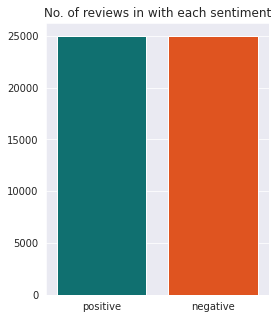

In [125]:
sns.set_style('darkgrid')
plt.figure(figsize=(4, 5))
sns.countplot(df['sentiment'], palette=['teal', 'orangered'])
plt.title('No. of reviews in with each sentiment')
plt.xlabel("")
plt.ylabel("")
plt.show()


In [131]:
# to remove non alphanumeric character
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

# to remove the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# to remove URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# to remove html tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [132]:
# apply preprocessing steps

df['review'] = df['review'].apply(remove_URL)
df['review'] = df['review'].apply(remove_html)
df['review'] = df['review'].str.lower()
df['review'] = df['review'].apply(alpha_num)
df['review'] = df['review'].apply(remove_stopwords)

df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


In [133]:
# container for sentences
reviews = np.array([review for review in df['review']])

# container for labels
labels = np.array([label for label in df['sentiment']])

In [134]:
# label encoding labels 

enc = LabelEncoder()
encoded_labels = enc.fit_transform(labels)

print(enc.classes_)
print(labels[:5])
print(encoded_labels[:5])

['negative' 'positive']
['positive' 'positive' 'positive' 'negative' 'positive']
[1 1 1 0 1]


In [135]:
# train-test split
train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(reviews, encoded_labels, 
                                                                                          test_size=0.33, 
                                                                                          stratify=labels)

In [141]:
vocab_size = len(word_index)
embedding_dim = 100
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [142]:
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

# convert validation dataset to sequence and pad sequences
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [146]:
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 100)          17165900  
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 17,233,149
Trainable params: 17,233,149
Non-trainable params: 0
_________________________________________________________________


In [147]:
# fit model
num_epochs = 10
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.33)

# predict values
pred = model.predict(validation_padded)

Epoch 1/10
702/702 - 162s - loss: 0.4145 - accuracy: 0.8015 - val_loss: 0.3256 - val_accuracy: 0.8602
Epoch 2/10
702/702 - 159s - loss: 0.1435 - accuracy: 0.9474 - val_loss: 0.3390 - val_accuracy: 0.8660
Epoch 3/10
702/702 - 158s - loss: 0.0139 - accuracy: 0.9974 - val_loss: 0.4156 - val_accuracy: 0.8681
Epoch 4/10
702/702 - 160s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.4624 - val_accuracy: 0.8667
Epoch 5/10
702/702 - 160s - loss: 2.4331e-04 - accuracy: 1.0000 - val_loss: 0.4922 - val_accuracy: 0.8660
Epoch 6/10
702/702 - 159s - loss: 1.2708e-04 - accuracy: 1.0000 - val_loss: 0.5210 - val_accuracy: 0.8659
Epoch 7/10
702/702 - 157s - loss: 7.1052e-05 - accuracy: 1.0000 - val_loss: 0.5500 - val_accuracy: 0.8660
Epoch 8/10
702/702 - 157s - loss: 3.7233e-05 - accuracy: 1.0000 - val_loss: 0.5883 - val_accuracy: 0.8658
Epoch 9/10
702/702 - 158s - loss: 1.8278e-05 - accuracy: 1.0000 - val_loss: 0.6284 - val_accuracy: 0.8659
Epoch 10/10
702/702 - 152s - loss: 9.3573e-06 - accuracy: 1.00

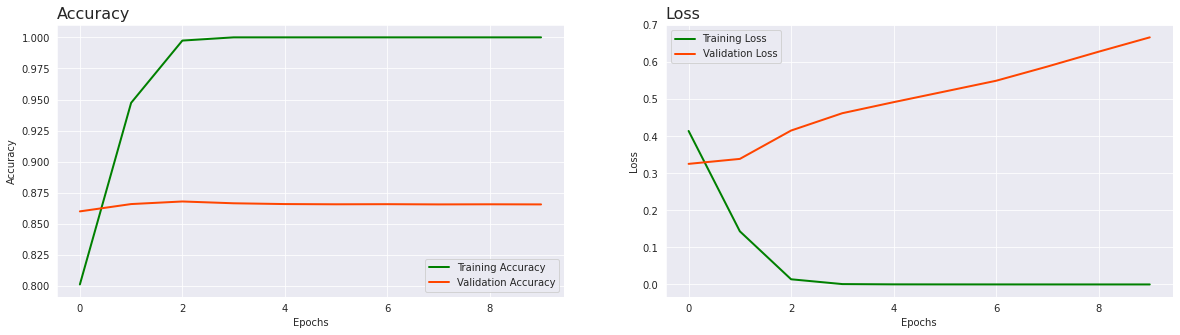

In [148]:
# plot history
plot_history(history)

In [151]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# preict the label
print(model.predict(padded))

[[1.000000e+00]
 [1.162032e-04]]
